In [1]:
!pip install -r requirements-pube.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import PIL

In [3]:
PIL.__version__

'6.2.2'

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime
import json
import yaml
from collections import defaultdict, Counter
from copy import deepcopy
from importlib import reload
from collections import Counter

In [5]:
%matplotlib inline

In [6]:
F.one_hot

<function torch._C._nn.one_hot>

In [7]:
#Add synchronized directory
#Remember to keep up to date on the local machine 
distsup_dir = "/home/jovyan/Documents/DistSup"
import sys
sys.path.append(distsup_dir)

In [8]:
from distsup import reconstructors_analysis
from distsup.reconstructors_analysis import style_modeling
from distsup.reconstructors_analysis.style_modeling.qmnist.dataset import get_dataset, get_full_dataset
from distsup.modules import pixcnn
from distsup.modules import quantizers

In [9]:
from distsup import utils
from distsup.modules import reconstructors, encoders, pixcnn
from distsup.models import vqvae, minitest, representation_learners
from distsup.data import PaddedDatasetLoader, FixedDatasetLoader, ChunkedDataset
from egs.mnist_seq.data import MNISTSequentialDataset

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

## Classes

In [12]:
num_levels = 16

In [13]:
class MnistStyleModel(nn.Module):
    def __init__(self, activation=F.leaky_relu):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 16, kernel_size=3)
        self.dropout = nn.Dropout2d()
        self.activation = activation

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, :]
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout(x)
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout(x)
        x = self.activation(self.conv3(x))
        return x.view(x.size(0), -1)

    @staticmethod
    def get_inputs(data, num_levels):
        x = data["images"].to(device)
        return (x * num_levels).clamp(0, num_levels - 1) / (num_levels - 1)

In [14]:
style_sizes = [8] #[1,2,4,8,16,32]

In [15]:
qmnist_full_train_set, qmnist_full_test_set = get_full_dataset(9, max_train_samples=60000)

In [16]:
len(qmnist_full_train_set)

60000

In [17]:
len(qmnist_full_train_set.dataset)

402953

In [18]:
train_loader = torch.utils.data.DataLoader(qmnist_full_train_set, batch_size=64, num_workers=1, shuffle=True)   
test_loader = torch.utils.data.DataLoader(qmnist_full_test_set, batch_size=64, num_workers=1, shuffle=False)   


In [19]:
embedding_sizes = [10]

In [20]:
digit_cond = {
    i: [
        {"cond_dim": 144, "reduction_factor": 0,},
        {"cond_dim": i, "reduction_factor": 0,},
    ]
    for i in embedding_sizes
}

In [21]:
models = {i: pixcnn.GatedPixelCNN(quantizer=dict(
                     class_name=quantizers.SoftmaxUniformQuantizer,
                     num_levels=num_levels
                     ),
                     cond_channels=digit_cond[i]).to(device)
         for i in embedding_sizes}

In [22]:
style_models = {
    i: MnistStyleModel().to(device)
    for i in embedding_sizes
}

In [23]:
from distsup.reconstructors_analysis.style_modeling import trainer, embedded

In [24]:
class GumbelSoftmax(nn.Softmax):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = temperature
        
    def forward(self, input):
        return F.gumbel_softmax(input, self.temperature, dim=self.dim)

In [25]:
import tqdm
one_hot_embeddings = torch.zeros((len(qmnist_full_train_set), 10))
for i in tqdm.trange(len(qmnist_full_train_set)):
    label = qmnist_full_train_set[i]["target_image_label"]
    one_hot_embeddings[i][label] = 1

100%|██████████| 60000/60000 [00:54<00:00, 1105.17it/s]


In [26]:
initialized_embedding_no_mask = embedded.MaskedEmbedding(len(qmnist_full_train_set), 10, _weight=one_hot_embeddings).to(device)

In [27]:
initialized_embedding_no_mask(torch.tensor(0).to(device))

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<EmbeddingBackward>)

In [28]:
initialized_embedding = embedded.MaskedEmbedding(len(qmnist_full_train_set), 10, mask=nn.Softmax(dim=-1), _weight=one_hot_embeddings).to(device)

In [29]:
initialized_embedding(torch.tensor(0).to(device)).data.cpu()

tensor([0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
        0.0853])

<BarContainer object of 10 artists>

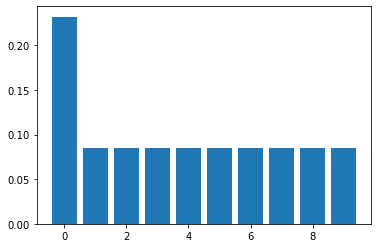

In [30]:
plt.bar(np.arange(10), initialized_embedding(torch.tensor(0).to(device)).data.cpu())

In [31]:
embeddings = {
    i: initialized_embedding_no_mask
    for i in embedding_sizes
}

In [74]:
trainers = {
    i: trainer.PixelCnnWithEmbeddingTrainer(
        models[i], 
        style_models[i], 
        train_loader,
        embedding=embeddings[i],
        serialization_filename=f"PixelCNN_embedding_dim_{i}_with_softmax_on_pretrained_reconstructor_with_initialized_softax_embeddings_60000_dataset_averaged_style_inputs_8",
        serialization_path="models/PixelCNN_embedding")
    for i in embedding_sizes
}

In [75]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-4)
    for i in embedding_sizes
}

In [76]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) 
    for i in embedding_sizes
}

In [77]:
emb_optims = {
    i: optim.Adam(embeddings[i].parameters(), lr=1e-4) 
    for i in embedding_sizes
}

## Load PixelCNN weights

In [79]:
models_path = "models/PixelCNN_averaged_style/"
model_file_tpl = "PixelCNN_averaged_style_inputs_{}"

In [80]:
models_files = os.listdir(models_path)

In [83]:
training_iter = 2

In [82]:
[file for file in models_files if file.startswith(model_file_tpl.format(8))]

['PixelCNN_averaged_style_inputs_8GatedPixelCNN_2020-07-26_17:37:53.pkl',
 'PixelCNN_averaged_style_inputs_8GatedPixelCNN_2020-07-27_03:56:46.pkl',
 'PixelCNN_averaged_style_inputs_8GatedPixelCNN_2020-07-26_22:56:32.pkl']

In [95]:
for size in embedding_sizes:
    model_files = [file for file in models_files if file.startswith(model_file_tpl.format(8))]
    model_files.sort()
    model_filepath = os.path.join(models_path, model_files[training_iter])
    checkpoint = torch.load(model_filepath)
    models[size].load_state_dict(checkpoint['model_state_dict'])
    style_models[size].load_state_dict(checkpoint['style_model_state_dict'])
    optims[size].load_state_dict(checkpoint['optimizer_model'])
    style_optims[size].load_state_dict(checkpoint['optimizer_style'])
    trainers[size].recon_losses = checkpoint['recon_losses']

In [263]:
models[10].gated_layers[0].v_to_h.weight.squeeze()[0]

tensor([-0.0358,  0.1602,  0.1346, -0.0626, -0.0257, -0.2645, -0.1010, -0.0919,
         0.2749,  0.0686, -0.1213,  0.0767, -0.1188,  0.2264, -0.0912,  0.2993,
         0.0344, -0.0109, -0.0355, -0.0046,  0.3091,  0.0492,  0.0607,  0.0683,
         0.1142,  0.1335, -0.1276,  0.0765,  0.0148, -0.0188, -0.2957, -0.2597,
        -0.0249, -0.1543,  0.0488,  0.1030,  0.1365,  0.2508, -0.0898,  0.1640,
         0.1267, -0.1751, -0.0437, -0.0160,  0.0084,  0.0233, -0.0848,  0.2183,
         0.1160,  0.2257, -0.0227, -0.1875,  0.1342,  0.1363, -0.0940, -0.1324,
        -0.1158, -0.0829,  0.1472, -0.0073,  0.0232,  0.1026, -0.0024, -0.2082],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
models[10].gated_layers[0].v_to_h.weight.squeeze()[0]

## Training

In [96]:
num_epochs = 30

In [97]:
for i in embedding_sizes:
    print(f"Starting embiedding {i} training")
    trainers[i].train([optims[i], style_optims[i], emb_optims[i]], num_epochs)

Starting embiedding 10 training
Train Epoch: 1 [0/60000 (0%)]	Loss: 14505.607422
Train Epoch: 1 [6400/60000 (11%)]	Loss: 15025.115234
Train Epoch: 1 [12800/60000 (21%)]	Loss: 14579.226562
Train Epoch: 1 [19200/60000 (32%)]	Loss: 15074.369141
Train Epoch: 1 [25600/60000 (43%)]	Loss: 15644.605469
Train Epoch: 1 [32000/60000 (53%)]	Loss: 14740.166016
Train Epoch: 1 [38400/60000 (64%)]	Loss: 14960.855469
Train Epoch: 1 [44800/60000 (75%)]	Loss: 15189.464844
Train Epoch: 1 [51200/60000 (85%)]	Loss: 14498.683594
Train Epoch: 1 [57600/60000 (96%)]	Loss: 14498.121094
Train Epoch: 2 [0/60000 (0%)]	Loss: 15558.355469
Train Epoch: 2 [6400/60000 (11%)]	Loss: 14720.759766
Train Epoch: 2 [12800/60000 (21%)]	Loss: 15090.730469
Train Epoch: 2 [19200/60000 (32%)]	Loss: 15018.921875
Train Epoch: 2 [25600/60000 (43%)]	Loss: 14982.604492
Train Epoch: 2 [32000/60000 (53%)]	Loss: 14501.820312
Train Epoch: 2 [38400/60000 (64%)]	Loss: 14048.074219
Train Epoch: 2 [44800/60000 (75%)]	Loss: 14472.861328
Train Ep

In [50]:
classify_embedding(embeddings[10], 10)

Training classifier

Test set: Average loss: 2.3004, Accuracy: 1103/10000 (11%)



In [98]:
emb_optims = {
    i: optim.Adam(embeddings[i].parameters(), lr=1e-3) 
    for i in embedding_sizes
}

In [99]:
for i in embedding_sizes:
    print(f"Starting embiedding {i} training")
    trainers[i].train([optims[i], style_optims[i], emb_optims[i]], num_epochs)

Starting embiedding 10 training
Train Epoch: 1 [0/60000 (0%)]	Loss: 14773.952148
Train Epoch: 1 [6400/60000 (11%)]	Loss: 14302.001953
Train Epoch: 1 [12800/60000 (21%)]	Loss: 14762.848633
Train Epoch: 1 [19200/60000 (32%)]	Loss: 14472.882812
Train Epoch: 1 [25600/60000 (43%)]	Loss: 14524.958008
Train Epoch: 1 [32000/60000 (53%)]	Loss: 15159.974609
Train Epoch: 1 [38400/60000 (64%)]	Loss: 14426.279297
Train Epoch: 1 [44800/60000 (75%)]	Loss: 14939.103516
Train Epoch: 1 [51200/60000 (85%)]	Loss: 13584.451172
Train Epoch: 1 [57600/60000 (96%)]	Loss: 13787.490234
Train Epoch: 2 [0/60000 (0%)]	Loss: 14382.017578
Train Epoch: 2 [6400/60000 (11%)]	Loss: 13847.658203
Train Epoch: 2 [12800/60000 (21%)]	Loss: 14290.250000
Train Epoch: 2 [19200/60000 (32%)]	Loss: 13465.966797
Train Epoch: 2 [25600/60000 (43%)]	Loss: 15005.423828
Train Epoch: 2 [32000/60000 (53%)]	Loss: 15806.594727
Train Epoch: 2 [38400/60000 (64%)]	Loss: 14585.838867
Train Epoch: 2 [44800/60000 (75%)]	Loss: 15195.503906
Train Ep

In [53]:
classify_embedding(embeddings[10], 10)

Training classifier

Test set: Average loss: 2.1071, Accuracy: 3139/10000 (31%)



In [100]:
emb_optims = {
    i: optim.Adam(embeddings[i].parameters(), lr=1e-4) 
    for i in embedding_sizes
}

In [101]:
for i in embedding_sizes:
    print(f"Starting embiedding {i} training")
    trainers[i].train([optims[i], style_optims[i], emb_optims[i]], num_epochs)

Starting embiedding 10 training
Train Epoch: 1 [0/60000 (0%)]	Loss: 13724.589844
Train Epoch: 1 [6400/60000 (11%)]	Loss: 14270.792969
Train Epoch: 1 [12800/60000 (21%)]	Loss: 13593.997070
Train Epoch: 1 [19200/60000 (32%)]	Loss: 13983.398438
Train Epoch: 1 [25600/60000 (43%)]	Loss: 14475.871094
Train Epoch: 1 [32000/60000 (53%)]	Loss: 14399.638672
Train Epoch: 1 [38400/60000 (64%)]	Loss: 13701.355469
Train Epoch: 1 [44800/60000 (75%)]	Loss: 14118.623047
Train Epoch: 1 [51200/60000 (85%)]	Loss: 14812.285156
Train Epoch: 1 [57600/60000 (96%)]	Loss: 14459.294922
Train Epoch: 2 [0/60000 (0%)]	Loss: 14307.011719
Train Epoch: 2 [6400/60000 (11%)]	Loss: 13970.347656
Train Epoch: 2 [12800/60000 (21%)]	Loss: 14580.886719
Train Epoch: 2 [19200/60000 (32%)]	Loss: 13902.744141
Train Epoch: 2 [25600/60000 (43%)]	Loss: 15054.187500
Train Epoch: 2 [32000/60000 (53%)]	Loss: 13623.019531
Train Epoch: 2 [38400/60000 (64%)]	Loss: 14238.949219
Train Epoch: 2 [44800/60000 (75%)]	Loss: 14412.876953
Train Ep

In [247]:
trainers[10].serialization_path="models/PixelCNN_embedding/pretrained_reconstructor/"
trainers[10].serialization_filename=f"PixelCNN_embedding_with_softmax_on_pretrained_reconstructor_training_all_models"
trainers[10].serialize([optims[10], style_optims[10], emb_optims[10]])

Model serialized as models/PixelCNN_embedding/pretrained_reconstructor/PixelCNN_embedding_with_softmax_on_pretrained_reconstructor_training_all_modelsGatedPixelCNN_2020-08-18_20:39:29.pkl


In [59]:
rec_losses = {
    i: [r.mean().item() for r in trainers[i].recon_losses] for i in embedding_sizes
}

In [60]:
for i, r in rec_losses.items():
    print(i, r[-1], len(r))

10 0.26923030614852905 450


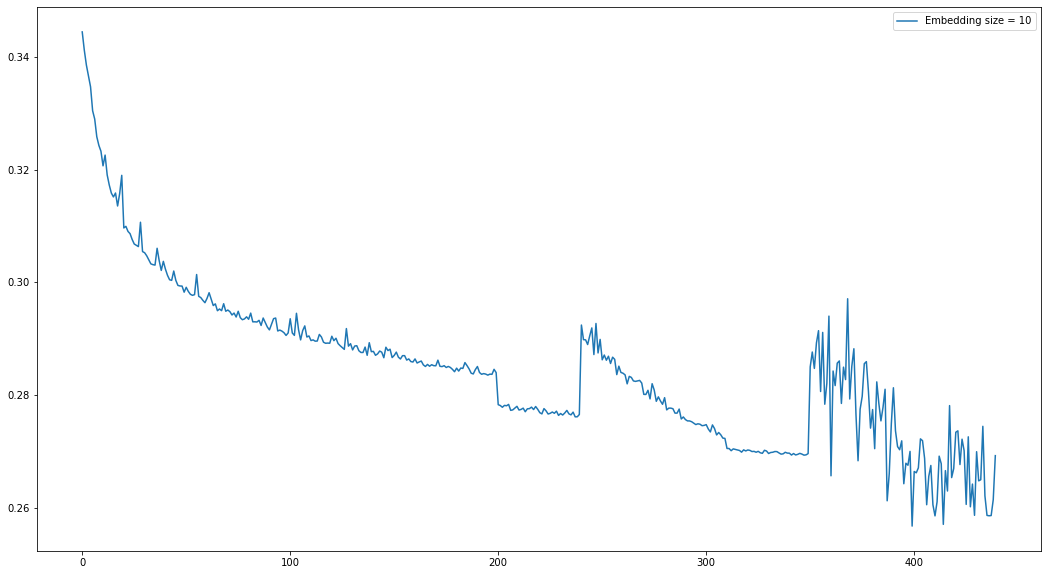

In [61]:
fig = plt.figure(figsize=(18,10))
for s in embedding_sizes:
    plt.plot(np.arange(len(rec_losses[s]) - 10), rec_losses[s][10:], label=f"Embedding size = {s}")
plt.legend()

In [27]:
models_path = "models/PixelCNN_embedding"
model_file_tpl = "PixelCNN_embedding_dim_{}_with_softmax_full_dataset_averaged_style_inputs_8"

In [267]:
models_path = "models/PixelCNN_embedding/pretrained_reconstructor"
model_file_tpl = "PixelCNN_embedding__with_softmax_on_pretrained_reconstructor_and_one_hot_embeddingGatedPixelCNN_2020-08-18_18:31:36.pkl"

In [272]:
models_files = os.listdir(models_path)

In [269]:
[file for file in models_files if file.startswith(model_file_tpl.format(10))]

['PixelCNN_embedding__with_softmax_on_pretrained_reconstructor_and_one_hot_embeddingGatedPixelCNN_2020-08-18_18:31:36.pkl']

In [273]:
training_iter = 0

In [281]:
for size in embedding_sizes:
    model_files = [file for file in models_files if file.startswith(model_file_tpl.format(size))]
    model_files.sort()
    model_filepath = os.path.join(models_path, model_files[training_iter])
    checkpoint = torch.load(model_filepath)
    models[size].load_state_dict(checkpoint['model_state_dict'])
    style_models[size].load_state_dict(checkpoint['style_model_state_dict'])
    optims[size].load_state_dict(checkpoint['optimizer_0'])
    style_optims[size].load_state_dict(checkpoint['optimizer_1'])
    trainers[size].recon_losses = checkpoint['recon_losses']
    
    emb_optims[size].load_state_dict(checkpoint['optimizer_2'])
    embeddings[size].load_state_dict(checkpoint['embedding'])

## Embedding classifier

In [49]:
def classify_embedding(embedding, epochs=6):
    classifier = nn.Sequential(
        nn.Linear(10, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=-1),
    ).to(device)
    train_set = embedded.EmbeddingDataset(embedding, qmnist_full_train_set, (0,50000))
    test_set = embedded.EmbeddingDataset(embedding, qmnist_full_train_set, (50000, 60000))
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=1, shuffle=False)
    criterion = nn.NLLLoss()
    classifier_optim = optim.SGD(classifier.parameters(), lr=1e-3, momentum=0.9)
    print("Training classifier")
    train_embedding_classifier(classifier, criterion, classifier_optim, train_loader, epochs, verbose=False)
    test_embedding_classifier(classifier, test_loader)
    

In [102]:
embedding_classifiers = {
    i: nn.Sequential(
        nn.Linear(i, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=-1),
    ).to(device)
    for i in embedding_sizes
}

In [103]:
embedding_train_sets = {
    i: embedded.EmbeddingDataset(embeddings[i], qmnist_full_train_set, (0,50000))
    for i in embedding_sizes
}

embedding_test_sets = {
    i: embedded.EmbeddingDataset(embeddings[i], qmnist_full_train_set, (50000, 60000))
    for i in embedding_sizes
}

In [104]:
embedding_train_loaders = {
    i: torch.utils.data.DataLoader(embedding_train_sets[i], batch_size=64, num_workers=1, shuffle=True)
    for i in embedding_sizes
}
embedding_test_loaders = {
    i: torch.utils.data.DataLoader(embedding_test_sets[i], batch_size=64, num_workers=1, shuffle=False)   
    for i in embedding_sizes
}

In [105]:
criterions = {
    i: nn.NLLLoss()
    for i in embedding_sizes
}
embedding_classifier_optims = {
    i: optim.SGD(embedding_classifiers[i].parameters(), lr=1e-3, momentum=0.9)
    for i in embedding_sizes
}

In [106]:
classifier_training_epochs = 20

In [107]:
def train_embedding_classifier(
    classifier, criterion, classifier_optim, embedding_loader, epochs, verbose=True
):
    classifier.train()
    for epoch in range(epochs):
        for batch_num, data in enumerate(embedding_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            classifier_optim.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            classifier_optim.step()
            if verbose and batch_num % 250 == 0:
                print(
                    f"Train Epoch: {epoch} [{batch_num * embedding_loader.batch_size}/{len(embedding_loader.dataset)}"
                    f"({100.0 * batch_num / len(embedding_loader):.0f}%)]\tLoss: {loss.item():.6f}"
                )

In [108]:
for i in embedding_sizes:
    print(f"Training embedding classifier {i}")
    train_embedding_classifier(
        embedding_classifiers[i],
        criterions[i],
        embedding_classifier_optims[i],
        embedding_train_loaders[i],
        classifier_training_epochs,
    )

Training embedding classifier 10
Train Epoch: 0 [0/50000(0%)]	Loss: 2.334877
Train Epoch: 0 [16000/50000(32%)]	Loss: 2.295635
Train Epoch: 0 [32000/50000(64%)]	Loss: 2.285915
Train Epoch: 0 [48000/50000(96%)]	Loss: 2.298007
Train Epoch: 1 [0/50000(0%)]	Loss: 2.284485
Train Epoch: 1 [16000/50000(32%)]	Loss: 2.283334
Train Epoch: 1 [32000/50000(64%)]	Loss: 2.273252
Train Epoch: 1 [48000/50000(96%)]	Loss: 2.278849
Train Epoch: 2 [0/50000(0%)]	Loss: 2.261681
Train Epoch: 2 [16000/50000(32%)]	Loss: 2.278574
Train Epoch: 2 [32000/50000(64%)]	Loss: 2.247516
Train Epoch: 2 [48000/50000(96%)]	Loss: 2.249205
Train Epoch: 3 [0/50000(0%)]	Loss: 2.257695
Train Epoch: 3 [16000/50000(32%)]	Loss: 2.277343
Train Epoch: 3 [32000/50000(64%)]	Loss: 2.233829
Train Epoch: 3 [48000/50000(96%)]	Loss: 2.239407
Train Epoch: 4 [0/50000(0%)]	Loss: 2.205982
Train Epoch: 4 [16000/50000(32%)]	Loss: 2.204898
Train Epoch: 4 [32000/50000(64%)]	Loss: 2.210482
Train Epoch: 4 [48000/50000(96%)]	Loss: 2.220491
Train Epoch:

In [109]:
def test_embedding_classifier(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [110]:
for i in embedding_sizes:
    print(f"Testing size {i}")
    test_embedding_classifier(embedding_classifiers[i], embedding_test_loaders[i])

Testing size 10

Test set: Average loss: 1.9227, Accuracy: 3315/10000 (33%)



In [266]:
#BEFORE EMBEDDING TRAINING
for size in embedding_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(10000)
    print(size, recs.mean().item())

10 0.2811899483203888


In [258]:
#EMBEDDING DEFAULT INIT, ALL MODEL TRAINED
for size in embedding_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(10000)
    print(size, recs.mean().item())

10 0.28088948130607605


In [139]:
#EMBEDDINGS (DEFAULT INIT) TRAINED, NO PIXELCNN/STYLE MODEL OPTIMIZING
for size in embedding_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(10000)
    print(size, recs.mean().item())

10 0.29314103722572327


In [201]:
#EMBEDDINGS (ONE HOT INIT) TRAINED, NO PIXELCNN/STYLE MODEL OPTIMIZING
for size in embedding_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(10000)
    print(size, recs.mean().item())

10 0.2661597728729248


In [62]:
# 02-09-2020
#EMBEDDINGS INITIALIZED AS SOFTMAXED ONE HOT, TRAINED THE SAME WAY BEFORE 
for size in embedding_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(10000)
    print(size, recs.mean().item())

10 0.2640013098716736


## Cond exploring

In [63]:
batch = next(iter(train_loader))

In [64]:
style, cond = trainers[10].get_conditioning(batch)

In [65]:
cond.argmax(dim=-1).view(-1)

tensor([4, 4, 9, 1, 2, 5, 1, 7, 2, 9, 0, 5, 2, 6, 1, 4, 1, 6, 0, 5, 6, 1, 0, 1,
        1, 1, 6, 5, 8, 7, 7, 9, 3, 5, 4, 2, 1, 2, 6, 3, 5, 7, 0, 7, 2, 1, 2, 5,
        9, 3, 4, 5, 0, 3, 0, 4, 4, 2, 9, 2, 2, 4, 4, 7], device='cuda:0')

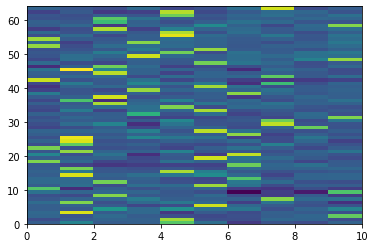

In [66]:
plt.pcolor(cond.data.cpu().view(64,-1))

In [67]:
batch["target_image_label"]

tensor([4, 4, 9, 1, 2, 5, 1, 7, 2, 9, 0, 5, 2, 6, 1, 4, 1, 6, 0, 5, 6, 1, 0, 1,
        1, 1, 6, 5, 8, 7, 7, 9, 3, 5, 4, 2, 1, 2, 6, 3, 5, 7, 0, 7, 2, 1, 2, 5,
        9, 3, 4, 5, 0, 3, 0, 4, 4, 2, 9, 2, 2, 4, 4, 7])

In [68]:
digits_cond = {i: [] for i in range(10)}
embedding_arg_max = {i: [] for i in range(10)}

In [69]:
for i in range(1000):
    emb = embeddings[10](torch.tensor(i).to(device))
    arg_max = emb.argmax().item()
    label = qmnist_full_train_set[i]["target_image_label"].item()
    digits_cond[label].append(emb.data.cpu().view(-1))
    embedding_arg_max[arg_max].append(label)

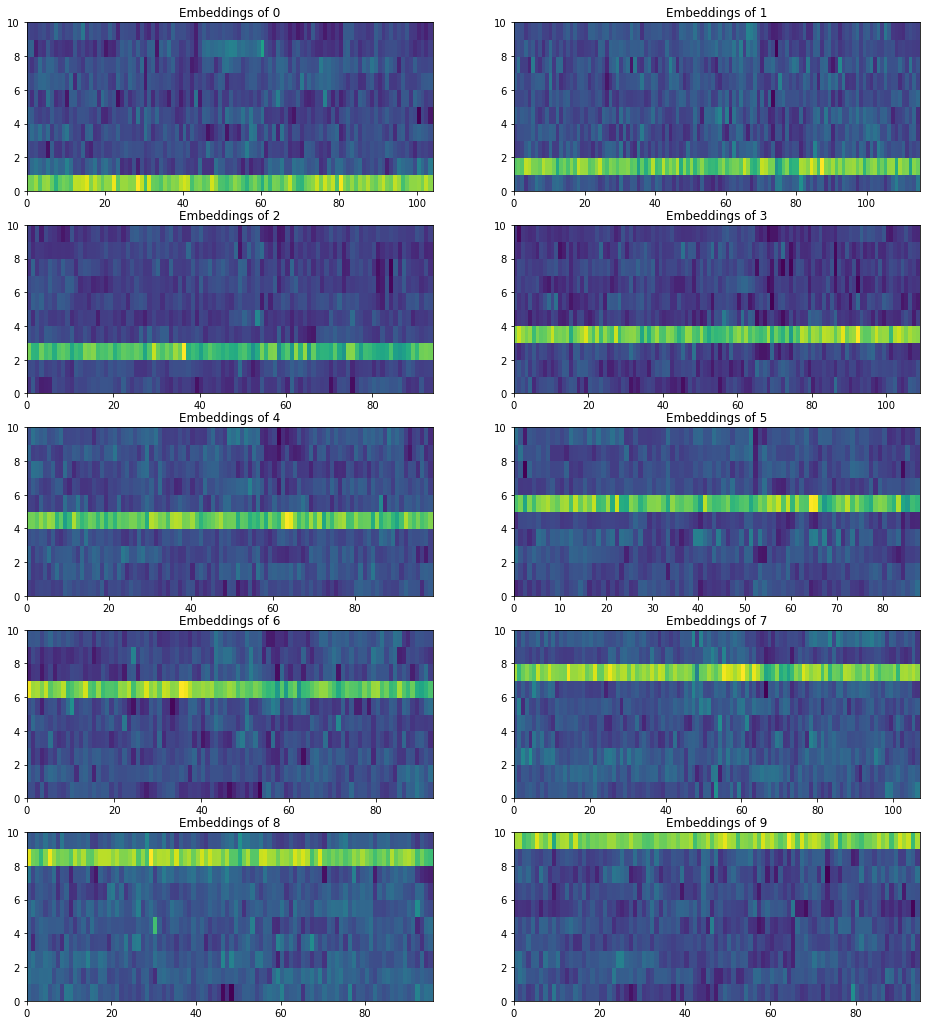

In [70]:
fig, axs = plt.subplots(5,2,figsize=(16,18))
for digit in range(10):
    axs[digit//2, digit%2].set_title(f"Embeddings of {digit}")
    axs[digit//2, digit%2].pcolor(np.vstack(digits_cond[digit]).T)
plt.show()